<b>CS225 - Project 3</b>
<br/>
U-ASK is a unified indexing and query processing for kNN spatial-keyword queries supporting negative keyword predicates

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from geopy.distance import geodesic
import copy
import time

In [2]:
class Point:
    def __init__(self, id, x, y, keywords):
        self.id = id
        self.x = x
        self.y = y
        self.keywords = keywords


In [3]:
class QuadTreeNode:
    def __init__(self, x0, y0, x1, y1, capacity=4, max_depth=10, depth=0):
        self.bounds = (x0, y0, x1, y1)
        self.capacity = capacity
        self.points = []
        self.divided = False
        self.children = []
        self.max_depth = max_depth
        self.depth = depth

    def insert(self, point):
        stack = [(self, point)]  # Stack of (node, point) pairs
        while stack:
            node, current_point = stack.pop()
            if not node.in_bounds(current_point):
                continue

            if len(node.points) < node.capacity or node.depth >= node.max_depth:
                node.points.append(current_point)
                continue

            if not node.divided:
                node.subdivide()

            for child in node.children:
                stack.append((child, current_point))

    def subdivide(self):
        x0, y0, x1, y1 = self.bounds
        mid_x = (x0 + x1) / 2
        mid_y = (y0 + y1) / 2

        self.children = [
            QuadTreeNode(x0, y0, mid_x, mid_y, self.capacity, self.max_depth, self.depth + 1),
            QuadTreeNode(mid_x, y0, x1, mid_y, self.capacity, self.max_depth, self.depth + 1),
            QuadTreeNode(x0, mid_y, mid_x, y1, self.capacity, self.max_depth, self.depth + 1),
            QuadTreeNode(mid_x, mid_y, x1, y1, self.capacity, self.max_depth, self.depth + 1),
        ]
        self.divided = True




    def in_bounds(self, point):
        x0, y0, x1, y1 = self.bounds
        return x0 <= point.x <= x1 and y0 <= point.y <= y1

    def query_range(self, x0, y0, x1, y1):
        points_in_range = []
        if not self.intersects(x0, y0, x1, y1):
            return points_in_range

        for point in self.points:
            if x0 <= point.x <= x1 and y0 <= point.y <= y1:
                points_in_range.append(point)

        if self.divided:
            for child in self.children:
                points_in_range.extend(child.query_range(x0, y0, x1, y1))

        return points_in_range

    def intersects(self, x0, y0, x1, y1):
        qx0, qy0, qx1, qy1 = self.bounds
        return not (x1 < qx0 or x0 > qx1 or y1 < qy0 or y0 > qy1)


In [4]:
class InvertedIndex:
    def __init__(self):
        self.index = {}

    def insert(self, point):
        for keyword in point.keywords:
            if keyword not in self.index:
                self.index[keyword] = set()
            self.index[keyword].add(point.id)

    def filter(self, keywords, negative_keywords):
        candidates = set()
        for keyword in keywords:
            if keyword in self.index:
                candidates.update(self.index[keyword])
        for neg_keyword in negative_keywords:
            if neg_keyword in self.index:
                candidates.difference_update(self.index[neg_keyword])
        return candidates


In [5]:
#POWER Algorithm (TKQN)**

def POWER(quadtree, inverted_index, query_coords, keywords, negative_keywords, k):
    # Spatial filtering (kNN using quadtree)
    x, y = query_coords
    radius = 0.1  # Initial search radius (adjust as needed)
    while True:
        spatial_candidates = quadtree.query_range(x - radius, y - radius, x + radius, y + radius)
        if len(spatial_candidates) >= k:
            break
        radius *= 2  # Expand search radius

    #Keyword filtering
    keyword_candidates = inverted_index.filter(keywords, negative_keywords)

    #Intersection and ranking
    final_candidates = [point for point in spatial_candidates if point.id in keyword_candidates]
    final_candidates.sort(key=lambda p: (p.x - x) ** 2 + (p.y - y) ** 2)  # Sort by distance

    # Return top-k results
    return final_candidates[:k]


In [6]:


def parse_line(line): 
    parts = line.strip().split()
    
    # Extract data
    object_id = int(parts[0])
    latitude = float(parts[1])
    longitude = float(parts[2])
    num_keywords = int(parts[3])
    
    keywords = []
    for i in range(num_keywords):
        keyword = parts[4 + i * 2]
        # weight = float(parts[5 + i * 2])
        keywords.append(keyword)

    return {
        "id": object_id,
        "x": latitude,
        "y": longitude,
        "keywords": keywords
    }

def parse_files(folder_path):
    data_points = []
    # Use glob to match all txt files
    file_list = glob.glob(os.path.join(folder_path, '*.txt'))
    
    for file_path in file_list:
        with open(file_path, 'r') as file:
            for line in file:
                # Parse each line and append to the data_points list
                data_point = parse_line(line)
                data_points.append(data_point)

    return data_points

folder_path = './data/data_4' 
data_points = parse_files(folder_path)


#print(data_points[:5])
print(f"Total number of data points: {len(data_points)}")

Total number of data points: 4000000


In [7]:
# import sys
# print(sys.executable)
#!pip3.9 install geopy

In [8]:

def group_queries_by_proximity(q, radius_miles=100):
    groups = []
    queries = copy.deepcopy(q)
    while queries:
        first_query = queries.pop(0)
        current_group = [first_query]
        current_group_coords = first_query[0]

        for other_query in queries[:]:
            other_query_coords = other_query[0]
            distance = geodesic(current_group_coords, other_query_coords).miles
            if distance <= radius_miles:
                current_group.append(other_query)
                queries.remove(other_query)

        groups.append(current_group)
    return groups


In [9]:
x_min, y_min = -180, -90  # Minimum longitude and latitude
x_max, y_max = 180, 90    # Maximum longitude and latitude

# Initialize the quadtree
quadtree = QuadTreeNode(x_min, y_min, x_max, y_max, capacity=4, max_depth=15,depth=0)

# Insert points
# for point in data_points:
#     point_obj = Point(point["id"], point["x"], point["y"], point["keywords"])
#     quadtree.insert(point_obj)

# Initialize the inverted index
inverted_index = InvertedIndex()




for point in data_points:
    # Create a Point object
    point_obj = Point(point["id"], point["x"], point["y"], point["keywords"])
    # Insert into the quadtree
    quadtree.insert(point_obj)
    # Insert into the inverted index
    inverted_index.insert(point_obj)


print("Quadtree and Inverted Index initialized successfully!")


Quadtree and Inverted Index initialized successfully!


In [10]:
from collections import defaultdict
#The function uses an expanding search radius to ensure that each query has at least k spatial candidates. 
def generate_spatial_candidates(quadtree, queries, k):
    query_radii = {}
    spatial_candidates = defaultdict(set)
    
    # Start with initial search radius
    initial_radius = 0.1  # adjust based on context
    for i, (query_coords, _, _) in enumerate(queries):
        x, y = query_coords
        radius = initial_radius
        while True:
            curr_candidates = set(quadtree.query_range(x - radius, y - radius, x + radius, y + radius))
            spatial_candidates[i].update(curr_candidates)
            if len(spatial_candidates[i]) >= k:
                query_radii[i] = radius
                break
            radius *= 2
    
    return spatial_candidates, query_radii
#performs an intersection between the spatial candidates and the keyword-based candidates
def filter_candidates_by_keywords(spatial_candidates, queries, inverted_index):
    final_candidates = {}
    
    for i, (_, keywords, negative_keywords) in enumerate(queries):
        keyword_candidates = inverted_index.filter(keywords, negative_keywords)
        # Intersect with spatial candidates
        intersected = [point for point in spatial_candidates[i] if point.id in keyword_candidates]
        final_candidates[i] = intersected
    
    return final_candidates

def process_queries_optimized(quadtree, inverted_index, queries, k):
    # Get spatial candidates for each query
    spatial_candidates, _ = generate_spatial_candidates(quadtree, queries, k)

    # Filter based on keywords
    all_candidates = filter_candidates_by_keywords(spatial_candidates, queries, inverted_index)

    # Sort by distance and retrieve top-k for each query
    results = {}
    for i, (query_coords, _, _) in enumerate(queries):
        x, y = query_coords
        sorted_by_distance = sorted(all_candidates[i], key=lambda p: (p.x - x) ** 2 + (p.y - y) ** 2)
        results[i] = sorted_by_distance[:k]
    
    return results

In [11]:

import json

# Load queries from a JSON file
with open("queries2.json", "r") as f:
    queries = json.load(f)

print(f"Loaded {len(queries)} queries from queries.json")

print (f" Number of queries : {len(queries)} queries \n")
groups_20 = group_queries_by_proximity(queries, 20)
print (f" Number of groups : {len(groups_20)} groups \n")
i=1
for group in groups_20:
    print(f" Group {i} : {group} \n")
    i+=1
    


Loaded 1000 queries from queries.json
 Number of queries : 1000 queries 

 Number of groups : 218 groups 

 Group 1 : [[[44.98276799743421, -92.44351572300718], ['seafood', 'burger'], ['greasy']], [[44.80516873701418, -92.54241743434532], ['coffee', 'steak'], ['spicy']], [[44.85353268464857, -92.08836596342977], ['salad', 'cheese'], ['sweet']], [[44.97849508381683, -92.23457700992546], ['sandwich', 'pasta'], ['tough']], [[44.971245299300236, -92.74921098585652], ['salad', 'steak'], ['cheap']], [[45.099589042773026, -92.66361210363698], ['vegan', 'sushi'], ['expensive']], [[44.87023420582332, -92.55518942284218], ['cheese', 'wine'], ['expensive']], [[44.987300318229174, -92.47160337084395], ['sandwich', 'sushi'], ['sour']], [[44.970816475773326, -92.62754561297666], ['wine', 'coffee'], ['bitter']], [[45.05312607307412, -92.71056370251871], ['sandwich', 'chocolate'], ['salty']], [[44.90618461590509, -92.32073923373436], ['sushi', 'vegan'], ['greasy']], [[44.987154301171344, -92.324110912

In [12]:
print("********************************** Original Power *************************************************")
#Original POWER (one-at-a-time)
start_time = time.time()
for query in queries:
    res= POWER(quadtree, inverted_index, *query, k=5)
    #print("Query Results:", res)
    print("Query Results:", [point.id for point in res])
original_latency = time.time() - start_time
print(f"Original POWER Latency: {original_latency:.4f} seconds")





********************************** Original Power *************************************************
Query Results: []
Query Results: [3805715, 3234329, 1030473, 1739258, 3591887]
Query Results: [3977892, 1016458, 3609800, 3921649, 1411826]
Query Results: [2053484, 396998, 1213993, 3236031, 3674317]
Query Results: [3914942, 1448972, 3624117, 2036259, 1956957]
Query Results: [69002, 3397439, 1238618, 2081957, 1970961]
Query Results: [1398352, 2360350, 2207842, 1153012, 807083]
Query Results: []
Query Results: []
Query Results: [956099, 21631, 786799, 1466174, 2653530]
Query Results: [2053484, 2274467, 1466174, 21631, 2768662]
Query Results: [2803142, 3804697, 3695205, 956099, 3090418]
Query Results: [786799, 1871145, 2558326, 2240437, 2082998]
Query Results: [843606]
Query Results: [21631, 1466174, 956099, 3327388, 2768662]
Query Results: [2112161, 3190390, 3131501]
Query Results: []
Query Results: [1093790, 3562501, 3538914, 1255465, 2748281]
Query Results: []
Query Results: []
Query Re

In [13]:
print("********************************** Batched Power (Radius 20 miles)**********************************")


start_time = time.time()
for group in groups_20:
    results = process_queries_optimized(quadtree, inverted_index, group, k=5)

    for i, result in results.items():
        print("Query Results:", [point.id for point in result])
batched_latency = time.time() - start_time
print(f"Batched POWER Latency: {batched_latency:.4f} seconds")

********************************** Batched Power (Radius 20 miles)**********************************
Query Results: []
Query Results: [1436952, 291834]
Query Results: [2456957, 14068, 974561, 844088, 3682383]
Query Results: []
Query Results: [2063154]
Query Results: [818121, 870550]
Query Results: [2456957, 14068, 974561, 3682383, 3644090]
Query Results: [818121, 870550]
Query Results: []
Query Results: [2467060, 2279981]
Query Results: [818121, 870550]
Query Results: [2063154]
Query Results: [818121, 870550]
Query Results: [2264525, 2407945, 781288, 1104614, 3601061]
Query Results: [3805715, 3234329, 1030473, 1739258, 3591887]
Query Results: []
Query Results: []
Query Results: [871156, 2231305, 7297, 929406, 1229933]
Query Results: [3385694]
Query Results: []
Query Results: [1868248]
Query Results: [2278107]
Query Results: [2092459, 2423044]
Query Results: []
Query Results: [2260220]
Query Results: [3591887]
Query Results: []
Query Results: []
Query Results: [10473, 225888, 56639, 368

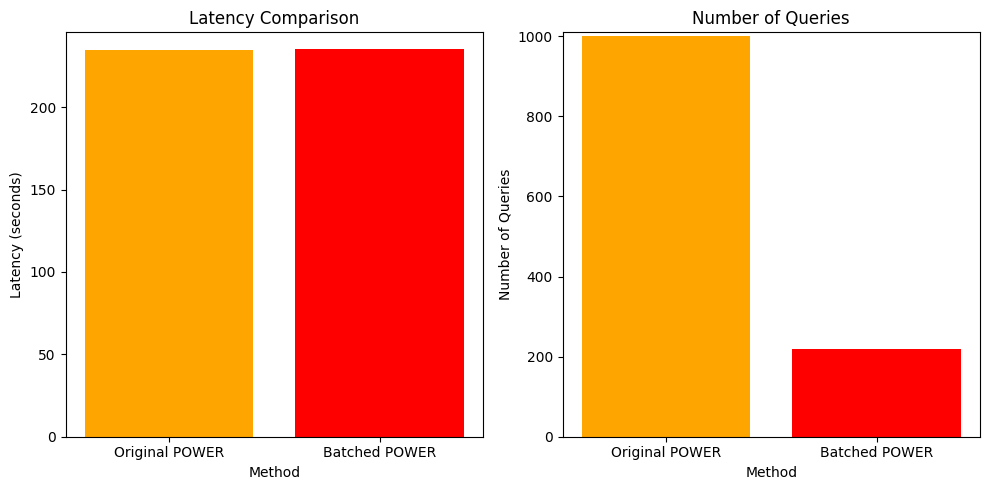

In [14]:

# Latency data
latencies = [original_latency, batched_latency]
methods = ['Original POWER', 'Batched POWER']

# Number of queries data
num_queries = [len(queries), len(groups_20)]

# Plotting latency comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # Create a subplot for latency
plt.bar(methods, latencies, color=['orange', 'red'])
plt.title('Latency Comparison')
plt.xlabel('Method')
plt.ylabel('Latency (seconds)')
plt.ylim(0, max(latencies) + 10)

# Plotting number of queries comparison
plt.subplot(1, 2, 2)  # Create a subplot for number of queries
plt.bar(methods, num_queries, color=['orange', 'red'])
plt.title('Number of Queries')
plt.xlabel('Method')
plt.ylabel('Number of Queries')
plt.ylim(0, max(num_queries) + 10)

# Show the plots
plt.tight_layout()  # Adjust subplot params so they fit in the figure
plt.show()

**Experiment A**

**Comparison of POWER-Patched and RCA (Power)**:



In [15]:
# Function to measure latency for POWER
def measure_latency_power(quadtree, inverted_index, queries, k):
    latencies = []
    for query in queries:
        query_coords, pos_keywords, neg_keywords = query
        start_time = time.time()
        POWER(quadtree, inverted_index, query_coords, pos_keywords, neg_keywords, k)
        end_time = time.time()
        latencies.append((len(pos_keywords), (end_time - start_time) * 1000))  # Latency in ms
    return latencies

# Function to measure latency for process_queries_optimized
def measure_latency_optimized(quadtree, inverted_index, queries, k):
    groups_100 = group_queries_by_proximity(queries, 20)
    #print(groups_100)
    start_time = time.time()
    for group in groups_100:
        process_queries_optimized(quadtree, inverted_index, group, k)
    end_time = time.time()
    return (end_time - start_time) * 1000  # Latency in milliseconds

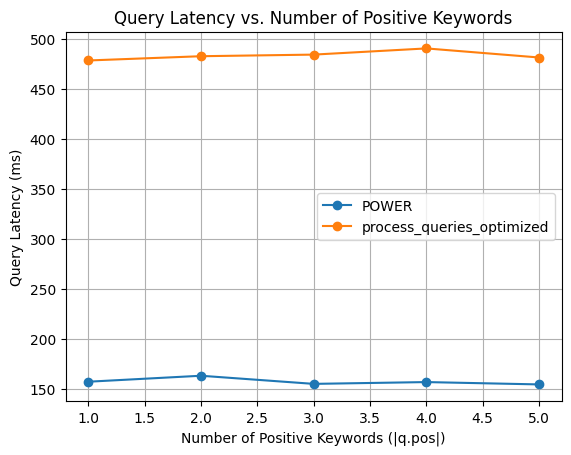

In [16]:
import random
import time
import matplotlib.pyplot as plt
from collections import defaultdict

# Predefined lists of positive and negative keywords
# positive_keywords = ['pizza', 'burger', 'coffee', 'wine', 'pasta', 'chocolate', 'steak', 'taco', 'sushi', 'vegan']
# negative_keywords = ['salty', 'sour', 'bitter', 'cheap', 'greasy', 'expensive', 'sweet', 'mild', 'spicy', 'tough']

# # Function to generate a query with a specific number of positive keywords
# def generate_query(num_pos_keywords):
#     # Random coordinates within the continental US
#     lat = random.uniform(24.0, 50.0)
#     lon = random.uniform(-125.0, -66.0)
    
#     # Randomly select positive and negative keywords
#     pos_keywords = random.sample(positive_keywords, num_pos_keywords)
#     neg_keywords = random.sample(negative_keywords, 1)
    
#     return ((lat, lon), pos_keywords, neg_keywords)




queries = [[[29.36433813328105, -98.01771488922265], ['cheese'], ['bitter']], [[29.333686124112845, -98.27416673497564], ['cheese'], ['greasy']], [[29.42678644043804, -97.80850814602991], ['burger', ], ['expensive']],[[29.36433813328105, -98.01771488922265], ['cheese', 'burger'], ['bitter']], [[29.333686124112845, -98.27416673497564], ['cheese', 'salad'], ['greasy']], 
[[29.42678644043804, -97.80850814602991], ['burger', 'sushi'], ['expensive']],[[29.36433813328105, -98.01771488922265], ['cheese', 'burger', 'toast'], ['bitter']], [[29.333686124112845, -98.27416673497564], ['cheese', 'salad', 'toast'], ['greasy']], 
[[29.42678644043804, -97.80850814602991], ['burger', 'sushi', 'toast'], ['expensive']],[[29.36433813328105, -98.01771488922265], ['cheese', 'burger', 'toast', 'soda'], ['bitter']], [[29.333686124112845, -98.27416673497564], ['cheese', 'salad', 'toast', 'soda'], ['greasy']], [[29.42678644043804, -97.80850814602991], ['burger', 'sushi', 'toast', 'soda'], ['expensive']],[[29.36433813328105, -98.01771488922265], ['cheese', 'burger', 'toast', 'soda', 'sauce'], ['bitter']], [[29.333686124112845, -98.27416673497564], ['cheese', 'salad','toast', 'soda','sauce'], ['greasy']], [[29.42678644043804, -97.80850814602991], ['burger', 'sushi','toast', 'soda', 'sauce'], ['expensive']]]
queries_by_pos = {}
for query in queries:
    num_pos = len(query[1])
    if num_pos not in queries_by_pos:
        queries_by_pos[num_pos] = []
    queries_by_pos[num_pos].append(query)
    


# Measure latency for both POWER and process_queries_optimized
latency_power_by_pos = defaultdict(list)
latency_optimized_by_pos = {}

for num_pos, queries in queries_by_pos.items():
    # Measure latency for POWER
    latencies = measure_latency_power(quadtree, inverted_index, queries, k=5)
    for pos, latency in latencies:
        latency_power_by_pos[pos].append(latency)
    
    # Measure latency for process_queries_optimized
    latency = measure_latency_optimized(quadtree, inverted_index, queries, k=5)
    latency_optimized_by_pos[num_pos] = latency

# Calculate average latency for POWER
avg_latency_power_by_pos = {}
for num_pos, latencies in latency_power_by_pos.items():
    avg_latency_power_by_pos[num_pos] = sum(latencies) / len(latencies)

# Prepare data for plotting
x = sorted(queries_by_pos.keys())  # |q.pos| values
y_power = [avg_latency_power_by_pos[num_pos] for num_pos in x]
y_optimized = [latency_optimized_by_pos[num_pos] for num_pos in x]

# Plot the results
plt.plot(x, y_power, marker='o', label="POWER")
plt.plot(x, y_optimized, marker='o', label="process_queries_optimized")
plt.xlabel("Number of Positive Keywords (|q.pos|)")
plt.ylabel("Query Latency (ms)")
plt.title("Query Latency vs. Number of Positive Keywords")
plt.legend()
plt.grid(True)
plt.show()

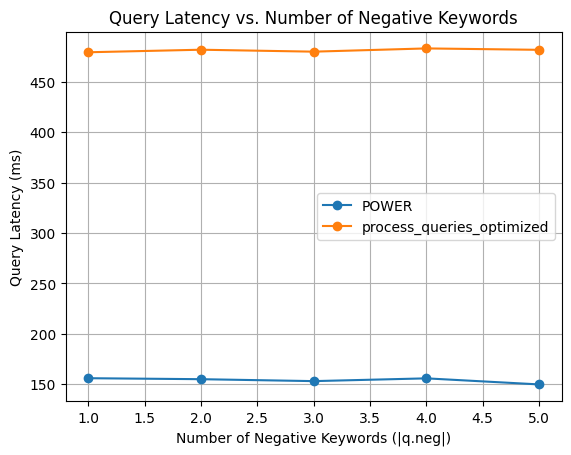

In [17]:
queries= [[[29.36433813328105, -98.01771488922265], ['cheese'], ['bitter']], [[29.333686124112845, -98.27416673497564], ['cheese'], ['greasy']], [[29.42678644043804, -97.80850814602991], ['burger', ], ['expensive']],[[29.36433813328105, -98.01771488922265], ['cheese', 'burger'], ['bitter', 'spicy']], [[29.333686124112845, -98.27416673497564], ['cheese', 'salad'], ['greasy', 'spicy']], 
[[29.42678644043804, -97.80850814602991], ['burger', 'sushi'], ['expensive', 'spicy']],[[29.36433813328105, -98.01771488922265], ['cheese', 'burger', 'toast'], ['bitter','greasy','expensive']],[[29.333686124112845, -98.27416673497564], ['cheese', 'salad', 'toast'], ['greasy', 'spicy', 'expensive']], [[29.42678644043804, -97.80850814602991], ['burger', 'sushi', 'toast'], ['expensive', 'bitter', 'ham']],[[29.36433813328105, -98.01771488922265], ['cheese', 'burger', 'toast', 'soda'], ['bitter','greasy', 'spicy', 'expensive']], [[29.333686124112845, -98.27416673497564], ['cheese', 'salad', 'toast', 'soda'], ['greasy','bitter','greasy','expensive']], [[29.42678644043804, -97.80850814602991], ['burger', 'sushi', 'toast', 'soda'], ['expensive', 'bitter','greasy', 'spicy']],[[29.36433813328105, -98.01771488922265], ['cheese', 'burger', 'toast', 'soda', 'sauce'], ['bitter','greasy', 'spicy', 'expensive', 'ham']], [[29.333686124112845, -98.27416673497564], ['cheese', 'salad','toast', 'soda','sauce'], ['greasy','spicy', 'expensive', 'ham', 'bitter']], [[29.42678644043804, -97.80850814602991], ['burger', 'sushi','toast', 'soda', 'sauce'], ['expensive','spicy', 'expensive', 'ham','greasy']]]
queries_by_neg = {}
for query in queries:
    num_neg = len(query[2])
    if num_neg not in queries_by_neg:
        queries_by_neg[num_neg] = []
    queries_by_neg[num_neg].append(query)

# Measure latency for both POWER and process_queries_optimized
latency_power_by_neg = defaultdict(list)
latency_optimized_by_neg = {}

for num_neg, queries in queries_by_neg.items():
    # Measure latency for POWER
    latencies = measure_latency_power(quadtree, inverted_index, queries, k=5)
    for neg, latency in latencies:
        latency_power_by_neg[neg].append(latency)
    
    # Measure latency for process_queries_optimized
    latency = measure_latency_optimized(quadtree, inverted_index, queries, k=5)
    latency_optimized_by_neg[num_neg] = latency

# Calculate average latency for POWER
avg_latency_power_by_neg = {}
for num_neg, latencies in latency_power_by_neg.items():
    avg_latency_power_by_neg[num_neg] = sum(latencies) / len(latencies)

# Prepare data for plotting
x = sorted(queries_by_neg.keys())  # |q.pos| values
y_power = [avg_latency_power_by_neg[num_neg] for num_neg in x]
y_optimized = [latency_optimized_by_neg[num_neg] for num_neg in x]


# Plot the results
plt.plot(x, y_power, marker='o', label="POWER")
plt.plot(x, y_optimized, marker='o', label="process_queries_optimized")
plt.xlabel("Number of Negative Keywords (|q.neg|)")
plt.ylabel("Query Latency (ms)")
plt.title("Query Latency vs. Number of Negative Keywords")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
#print (queries_by_neg)

### exp c

In [19]:
# queries = [[[29.36433813328105, -98.01771488922265], ['cheese'], ['bitter']], [[29.333686124112845, -98.27416673497564], ['cheese'], ['greasy']], [[29.42678644043804, -97.80850814602991], ['burger', ], ['expensive']],[[29.36433813328105, -98.01771488922265], ['cheese', 'burger'], ['bitter spicy']], [[29.333686124112845, -98.27416673497564], ['cheese', 'salad'], ['greasy spicy']], [[29.42678644043804, -97.80850814602991], ['burger', 'sushi'], ['expensive spicy']],[[29.36433813328105, -98.01771488922265], ['cheese', 'burger'], ['bitter greasy expensive']],[[29.333686124112845, -98.27416673497564], ['cheese', 'salad'], ['greasy spicy expensive']], [[29.42678644043804, -97.80850814602991], ['burger', 'sushi' ], ['expensive bitter ham']],[[29.36433813328105, -98.01771488922265], ['cheese', 'burger'], ['bitter greasy spicy expensive']], [[29.333686124112845, -98.27416673497564], ['cheese', 'salad'], ['greasy bitter greasy expensive']], [[29.42678644043804, -97.80850814602991], ['burger', 'sushi' ], ['expensive bitter greasy spicy']],[[29.36433813328105, -98.01771488922265], ['cheese', 'burger'], ['bitter greasy spicy expensive ham']], [[29.333686124112845, -98.27416673497564], ['cheese', 'salad'], ['greasy spicy expensive ham bitter']], [[29.42678644043804, -97.80850814602991], ['burger', 'sushi'], ['expensive spicy expensive ham greasy']]]
# def count_words(string_list):
#     if not string_list:  # Handle empty list case
#         return 0
#     string = string_list[0]  # Extract the string
#     words = string.split()  # Split the string into words
#     return len(words)  # Return the number of words

# queries_by_negLen = {}
# for query in queries:
#     num_negLen = count_words(query[2])
#     if num_negLen not in queries_by_negLen:
#         queries_by_negLen[num_negLen] = []
#     queries_by_negLen[num_negLen].append(query)

# #print(queries_by_negLen)

# # Measure latency for both POWER and process_queries_optimized
# latency_power_by_negLen = defaultdict(list)
# latency_optimized_by_negLen = {}

# for num_negLen, queries in queries_by_negLen.items():
#     # Measure latency for POWER
#     latencies = measure_latency_power(quadtree, inverted_index, queries, k=5)
#     for negLen, latency in latencies:
#         latency_power_by_negLen[negLen].append(latency)
    
#     # Measure latency for process_queries_optimized
#     latency = measure_latency_optimized(quadtree, inverted_index, queries, k=5)
#     latency_optimized_by_negLen[num_negLen] = latency

# # Calculate average latency for POWER
# avg_latency_power_by_negLen = {}
# for num_negLen, latencies in latency_power_by_pos.items():
#     avg_latency_power_by_negLen[num_negLen] = sum(latencies) / len(latencies)

# # Prepare data for plotting
# x = sorted(queries_by_pos.keys())  # |q.pos| values
# y_power = [avg_latency_power_by_negLen[num_negLen] for num_negLen in x]
# y_optimized = [latency_optimized_by_negLen[num_negLen] for num_negLen in x]

# # Plot the results
# plt.plot(x, y_power, marker='o', label="POWER")
# plt.plot(x, y_optimized, marker='o', label="Batched POWER")
# plt.xlabel("Number of Positive Keywords (|q.negLen|)")
# plt.ylabel("Query Latency (ms)")
# plt.title("Query Latency vs. Number of Negative Phrases")
# plt.legend()
# plt.grid(True)
# plt.show()


In [20]:
import json
import random
# Load queries from a JSON file
with open("queries_c.json", "r") as f:
    queries = json.load(f)
    
def count_words(string_list):
    if not string_list:  # Handle empty list case
        return 0
    string = string_list[0]  # Extract the string
    words = string.split()  # Split the string into words
    return len(words)  # Return the number of words

queries_by_negLen = {}
for query in queries:
    num_negLen = count_words(query[2])
    if num_negLen not in queries_by_negLen:
        queries_by_negLen[num_negLen] = []
    queries_by_negLen[num_negLen].append(query)

#print(queries_by_negLen)

# Measure latency for both POWER and process_queries_optimized
latency_power_by_negLen = defaultdict(list)
latency_optimized_by_negLen = {}

for num_negLen, queries in queries_by_negLen.items():
    # Measure latency for POWER
    latencies = measure_latency_power(quadtree, inverted_index, queries, k=5)
    for negLen, latency in latencies:
        latency_power_by_negLen[negLen].append(latency)
    
    # Measure latency for process_queries_optimized
    latency = measure_latency_optimized(quadtree, inverted_index, queries, k=5)
    latency_optimized_by_negLen[num_negLen] = latency


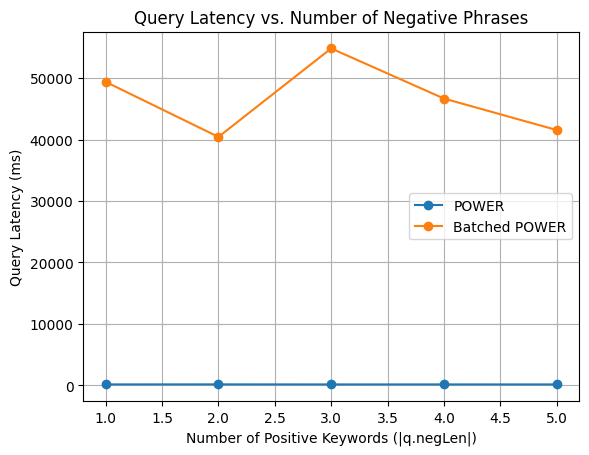

In [ ]:
# Calculate average latency for POWER
avg_latency_power_by_negLen = {}
for num_negLen, latencies in latency_power_by_pos.items():
    avg_latency_power_by_negLen[num_negLen] = sum(latencies) / len(latencies)

# Prepare data for plotting
x = sorted(queries_by_pos.keys())  # |q.pos| values
y_power = [avg_latency_power_by_negLen[num_negLen] for num_negLen in x]
y_optimized = [latency_optimized_by_negLen[num_negLen] for num_negLen in x]

# Plot the results
plt.plot(x, y_power, marker='o', label="POWER")
plt.plot(x, y_optimized, marker='o', label="Batched POWER")
plt.xlabel("Number of Positive Keywords (|q.negLen|)")
plt.ylabel("Query Latency (ms)")
plt.title("Query Latency vs. Number of Negative Phrases")
plt.legend()
plt.grid(True)
plt.show()